# Assignment 1
## IN3050 - Introduksjon til kunstig intelligens og maskinlæring
### Author: Karsten Sveia - karsteas@uio.no

### Imports for the submission

In [1]:
import csv, time, os
from itertools import permutations
import matplotlib.pyplot as plt

### Importing the csv file and checking the data

In [2]:
with open("european_cities.csv", "r", encoding="utf-8") as f:
    rows = list(csv.reader(f, delimiter=";"))

cities = rows[0]  # header row with city names
print("Cities in the file:", len(cities))
print("First 5 cities:", cities[:5])

Cities in the file: 24
First 5 cities: ['Barcelona', 'Belgrade', 'Berlin', 'Brussels', 'Bucharest']


### Helper functions etc

In [3]:
# distance lookup: dist[a][b] in km
dist = {c: {} for c in cities}
for i in range(1, len(rows)):
    a = cities[i-1]
    vals = rows[i]
    for j, b in enumerate(cities):
        dist[a][b] = float(vals[j])

# total length of a full route (includes return to start)
def sum_tour_km(route, dist):
    total = 0.0
    for i in range(len(route)-1):
        total += dist[route[i]][route[i+1]]
    return total

# Adding the map.png
europe_map = plt.imread("map.png") if os.path.exists("map.png") else None

# coordinates for plotting provided by the professor
CITY_COORDS = {
    "Barcelona":[2.154007,41.390205],"Belgrade":[20.46,44.79],"Berlin":[13.40,52.52],
    "Brussels":[4.35,50.85],"Bucharest":[26.10,44.44],"Budapest":[19.04,47.50],
    "Copenhagen":[12.57,55.68],"Dublin":[-6.27,53.35],"Hamburg":[9.99,53.55],
    "Istanbul":[28.98,41.02],"Kyiv":[30.52,50.45],"London":[-0.12,51.51],
    "Madrid":[-3.70,40.42],"Milan":[9.19,45.46],"Moscow":[37.62,55.75],
    "Munich":[11.58,48.14],"Paris":[2.35,48.86],"Prague":[14.42,50.07],
    "Rome":[12.50,41.90],"Saint Petersburg":[30.31,59.94],"Sofia":[23.32,42.70],
    "Stockholm":[18.06,60.33],"Vienna":[16.36,48.21],"Warsaw":[21.02,52.24]
}

def c_plot(route, title="tour"):
    fig, ax = plt.subplots(figsize=(7,7))
    if europe_map is not None:
        ax.imshow(europe_map, extent=[-14.56, 38.43, 38.0, 66.0], aspect="auto", zorder=0)

    color = "tab:blue"
    for i in range(len(route)-1):
        x1,y1 = CITY_COORDS[route[i]]; x2,y2 = CITY_COORDS[route[i+1]]
        ax.plot([x1,x2],[y1,y2], linewidth=2, color=color, zorder=2)
    x0,y0 = CITY_COORDS[route[0]]; xl,yl = CITY_COORDS[route[-1]]
    ax.plot([xl,x0],[yl,y0], linewidth=2, color=color, zorder=2)

    for i, name in enumerate(route[:-1], start=1):
        x,y = CITY_COORDS[name]
        ax.plot(x, y, marker='o', markersize=4, color="black", zorder=3)
        ax.text(x, y, str(i), fontsize=9, ha="center", va="center",
                bbox=dict(boxstyle="circle,pad=0.25", fc="white", ec="black", lw=0.5, alpha=0.85),
                zorder=4)

    sx, sy = CITY_COORDS[route[0]]
    ax.plot(sx, sy, marker="*", markersize=14, color="gold", mec="black", mew=0.8, zorder=5)
    ax.text(sx, sy, " start/end", fontsize=9, ha="left", va="center",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9), zorder=5)

    ax.set_title(title); ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    plt.tight_layout(); plt.show()

# Styling and formating
def city_plot_axes(ax, route, title="tour"):
    if europe_map is not None:
        ax.imshow(europe_map, extent=[-14.56, 38.43, 38.0, 66.0], aspect="auto", zorder=0)
    color = "tab:blue"
    for i in range(len(route)-1):
        x1,y1 = CITY_COORDS[route[i]]; x2,y2 = CITY_COORDS[route[i+1]]
        ax.plot([x1,x2],[y1,y2], linewidth=2, color=color, zorder=2)
    x0,y0 = CITY_COORDS[route[0]]; xl,yl = CITY_COORDS[route[-1]]
    ax.plot([xl,x0],[yl,y0], linewidth=2, color=color, zorder=2)
    for i, name in enumerate(route[:-1], start=1):
        x,y = CITY_COORDS[name]
        ax.plot(x, y, marker='o', markersize=4, color="black", zorder=3)
        ax.text(x, y, str(i), fontsize=9, ha="center", va="center",
                bbox=dict(boxstyle="circle,pad=0.25", fc="white", ec="black", lw=0.5, alpha=0.85),
                zorder=4)
    sx, sy = CITY_COORDS[route[0]]
    ax.plot(sx, sy, marker="*", markersize=14, color="gold", mec="black", mew=0.8, zorder=5)
    ax.text(sx, sy, " start/end", fontsize=9, ha="left", va="center",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9), zorder=5)
    ax.set_title(title)

## Task 1 - Exhaustive Search

The task will be divided up into three parts which will be:
- 1 Writing a program to find the shortest tour among a subset of the first 6 cities
- 2 Presenting in a table the program time for calculating the best route for the salesman
- 3 Plotting a map of the shortest tour for a route consisting of 6 and 10 cities
- 4 Calculating a approximation of how long it would take to find the best solution for all 24 cities

### Creating the algorithm for the exhaustive search

k=6 | routes_checked=120 | distance=5018.81 km | time=0.000059 s
route: Barcelona -> Belgrade -> Bucharest -> Budapest -> Berlin -> Brussels -> Barcelona


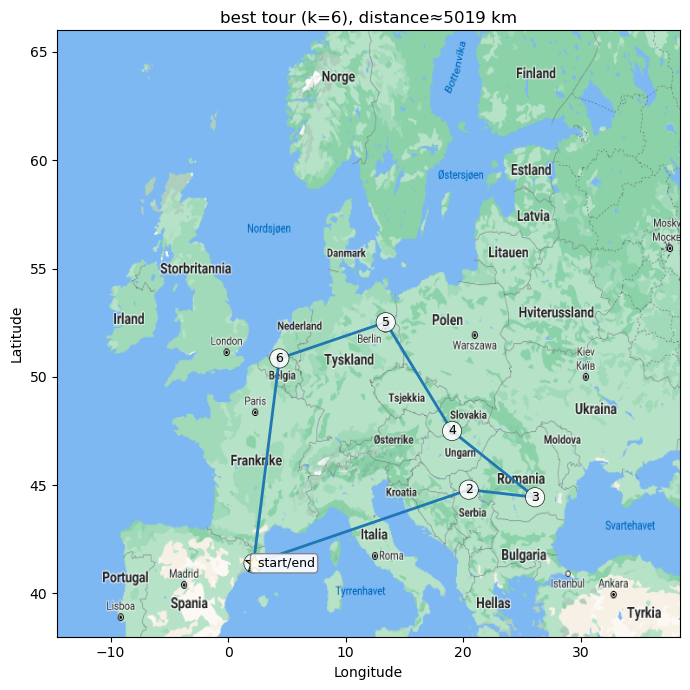

In [4]:
def exh_best_k(k, start_city=None):
    subset = cities[:k]
    start = subset[0] if start_city is None else start_city
    if start not in subset: raise ValueError("start_city must be within the first k cities.")
    subset = [start] + [c for c in subset if c != start]
    others = subset[1:]

    best_route, best_len, checked = None, float("inf"), 0
    t0 = time.perf_counter()
    for order in permutations(others):
        route = [start, *order, start]
        L = sum_tour_km(route, dist)
        checked += 1
        if L < best_len:
            best_len, best_route = L, route
    t1 = time.perf_counter()
    return {"k":k, "best_route":best_route, "best_len":best_len,
            "checked":checked, "time_sec":t1-t0}

res6 = exh_best_k(6)
print(f"k=6 | routes_checked={res6['checked']:,} | distance={res6['best_len']:.2f} km | time={res6['time_sec']:.6f} s")
print("route:", " -> ".join(res6["best_route"]))
c_plot(res6["best_route"], title=f"best tour (k=6), distance≈{round(res6['best_len'])} km")

In [5]:
# Table of k = 4 to k = 12 iterations

rows_tbl = []
for k in range(4, 13):
    r = exh_best_k(k)
    rows_tbl.append(r)

print("k | routes_checked    | best_len | time (s)")
print("--+--------------------+----------+-----------")
for r in rows_tbl:
    print(f"{r['k']:>2} | {r['checked']:>18,} | {round(r['best_len']):>8} | {r['time_sec']:>9.3f}")

k | routes_checked    | best_len | time (s)
--+--------------------+----------+-----------
 4 |                  6 |     4242 |     0.000
 5 |                 24 |     4983 |     0.000
 6 |                120 |     5019 |     0.000
 7 |                720 |     5488 |     0.000
 8 |              5,040 |     6667 |     0.003
 9 |             40,320 |     6679 |     0.023
10 |            362,880 |     7486 |     0.214
11 |          3,628,800 |     8339 |     2.202
12 |         39,916,800 |     8347 |    27.104


k=6  | routes_checked=120  | distance=5018.81 km  | time=0.000059 s
      route: Barcelona -> Belgrade -> Bucharest -> Budapest -> Berlin -> Brussels -> Barcelona
k=10 | routes_checked=362,880 | distance=7486.31 km | time=0.210534 s
      route: Barcelona -> Belgrade -> Istanbul -> Bucharest -> Budapest -> Berlin -> Copenhagen -> Hamburg -> Brussels -> Dublin -> Barcelona


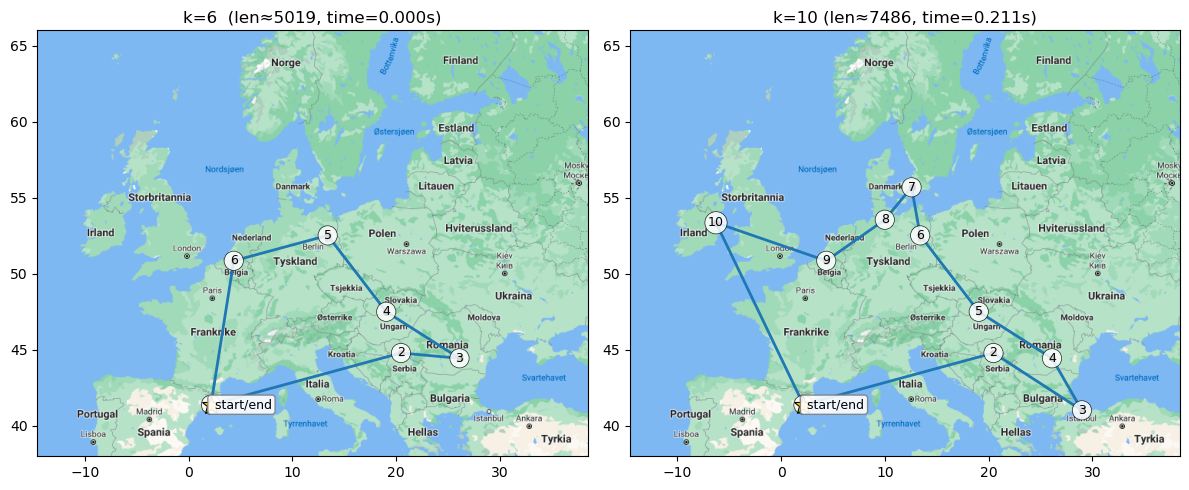

In [6]:
res10 = exh_best_k(10)
res12 = exh_best_k(12)

# Summary and the route of k = 6 and k = 10
print(f"k=6  | routes_checked={res6['checked']:,}  | distance={res6['best_len']:.2f} km  | time={res6['time_sec']:.6f} s")
print("      route:", " -> ".join(res6["best_route"]))
print(f"k=10 | routes_checked={res10['checked']:,} | distance={res10['best_len']:.2f} km | time={res10['time_sec']:.6f} s")
print("      route:", " -> ".join(res10["best_route"]))

fig, axes = plt.subplots(1, 2, figsize=(12,5))
city_plot_axes(axes[0], res6["best_route"],  f"k=6  (len≈{round(res6['best_len'])}, time={res6['time_sec']:.3f}s)")
city_plot_axes(axes[1], res10["best_route"], f"k=10 (len≈{round(res10['best_len'])}, time={res10['time_sec']:.3f}s)")
plt.tight_layout(); plt.show()

### Time calculation
Using some simple math, by taking the sum from the k = 12, the time hundreds of thousands of years, making exhaustive search infeasible or not "possible" as shown under.

In [7]:
import math

t12 = res12["time_sec"]  # bruk målingen din fra Block 6
sec_per_tour = t12 / math.factorial(11)
t24_sec = sec_per_tour * math.factorial(23)

def wtf(seconds):
    minute = 60
    hour = 60*minute
    day = 24*hour
    year = 365*day
    if seconds < minute:   return f"{seconds:.2f} s"
    if seconds < hour:     return f"{seconds/minute:.2f} min"
    if seconds < day:      return f"{seconds/hour:.2f} h"
    if seconds < year:     return f"{seconds/day:.2f} days"
    return f"{seconds/year:.2f} years"

print("≈ average sec per tour (from k=12):", sec_per_tour)
print("≈ estimated time for 24 cities:", wtf(t24_sec))

≈ average sec per tour (from k=12): 6.677796744230244e-07
≈ estimated time for 24 cities: 547420450.31 years


## Task 2 - Hill climbing
- First creating some definitions etc for the algorithm

In [8]:
import random, time, statistics

def route_len_o(order, dist):
    total, n = 0.0, len(order)
    for i in range(n):
        total += dist[order[i]][order[(i+1) % n]]
    return total

def opt_best2(order, dist):
    n = len(order)
    base_len = route_len_o(order, dist)
    best_delta, best_i, best_j = 0.0, None, None
    for i in range(1, n-1):           # keep index 0 as fixed start
        for j in range(i+1, n):
            new_order = order[:i] + list(reversed(order[i:j])) + order[j:]
            new_len = route_len_o(new_order, dist)
            delta = new_len - base_len
            if delta < best_delta:
                best_delta, best_i, best_j = delta, i, j
    if best_i is None:
        return None, base_len
    improved = order[:best_i] + list(reversed(order[best_i:best_j])) + order[best_j:]
    return improved, base_len + best_delta

def hc_2opt(cities_subset, dist, max_iters=10_000, rng=None):
    rng = rng or random
    start = cities_subset[0]
    rest = cities_subset[1:].copy()
    rng.shuffle(rest)
    order = [start] + rest

    t0, iters = time.perf_counter(), 0
    while iters < max_iters:
        new_order, _ = opt_best2(order, dist)
        iters += 1
        if new_order is None:
            break
        order = new_order

    return {
        "best_order_open": order,
        "best_len": route_len_o(order, dist),
        "iters": iters,
        "time_sec": time.perf_counter() - t0
    }

def close_r_op(order_open):
    return order_open + [order_open[0]]

def hc_runs_for_k(k, runs=20, seed=None):
    rng = random.Random(seed)
    subset = cities[:k]
    lengths, times = [], []
    best_res = None
    for _ in range(runs):
        res = hc_2opt(subset, dist, rng=rng)
        lengths.append(res["best_len"])
        times.append(res["time_sec"])
        if (best_res is None) or (res["best_len"] < best_res["best_len"]):
            best_res = res
    return {
        "k": k, "runs": runs,
        "best": min(lengths), "worst": max(lengths),
        "mean": statistics.mean(lengths), "std": statistics.pstdev(lengths),
        "time_mean": statistics.mean(times), "time_std": statistics.pstdev(times),
        "best_order_open": best_res["best_order_open"]
    }

def hc_runs_collect(k, runs=20, seed=None):
    rng = random.Random(seed)
    subset = cities[:k]
    results = []
    for _ in range(runs):
        results.append(hc_2opt(subset, dist, rng=rng))
    # summary too
    lens = [r["best_len"] for r in results]
    times = [r["time_sec"] for r in results]
    best_ix = min(range(runs), key=lambda i: lens[i])
    summary = {
        "k": k, "runs": runs,
        "best": min(lens), "worst": max(lens),
        "mean": statistics.mean(lens), "std": statistics.pstdev(lens),
        "time_mean": statistics.mean(times), "time_std": statistics.pstdev(times),
        "best_order_open": results[best_ix]["best_order_open"]
    }
    return results, summary

Hill Climbing (k=10, 20 runs)
best = 7486.31 km | worst = 8538.94 km | mean = 7833.17 km | std = 378.52 km
avg time/run = 0.0003 s (std 0.0001 s)


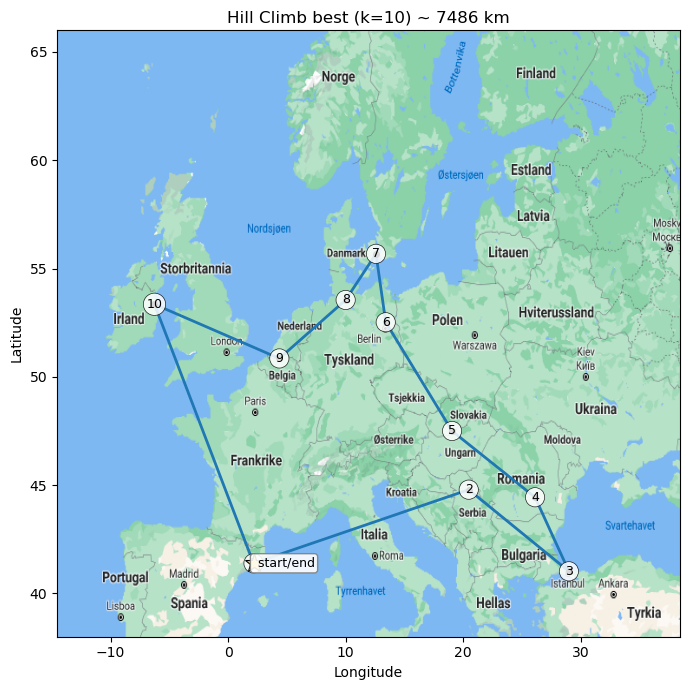

In [9]:
# k=10 with 20 runs: stats + one plot summary

hc10 = hc_runs_for_k(10, runs=20, seed=None)

print(f"Hill Climbing (k=10, 20 runs)")
print(f"best = {hc10['best']:.2f} km | worst = {hc10['worst']:.2f} km | mean = {hc10['mean']:.2f} km | std = {hc10['std']:.2f} km")
print(f"avg time/run = {hc10['time_mean']:.4f} s (std {hc10['time_std']:.4f} s)")

best_route10_closed = close_r_op(hc10["best_order_open"])
c_plot(best_route10_closed, title=f"Hill Climb best (k=10) ~ {hc10['best']:.0f} km")

Hill Climbing (k=24, 20 runs)
best = 12705.38 km | worst = 15499.82 km | mean = 13616.79 km | std = 776.85 km
avg time/run = 0.0084 s (std 0.0008 s)


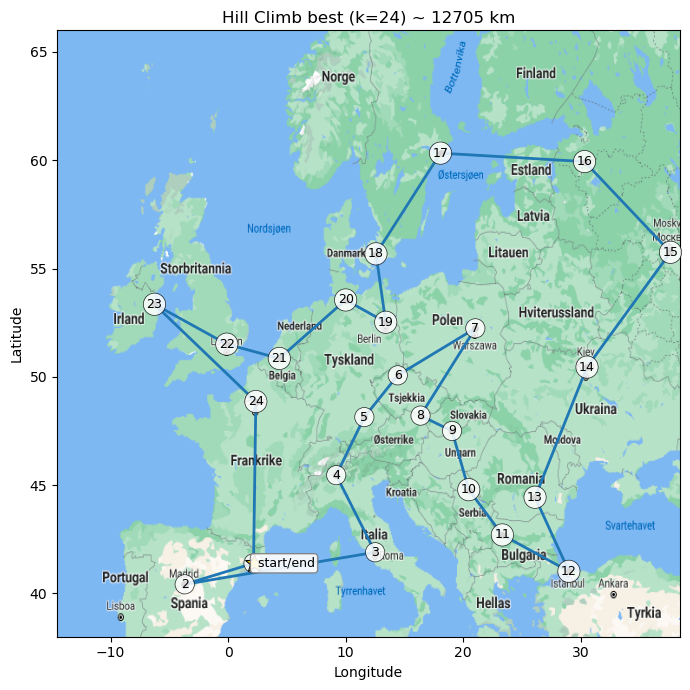

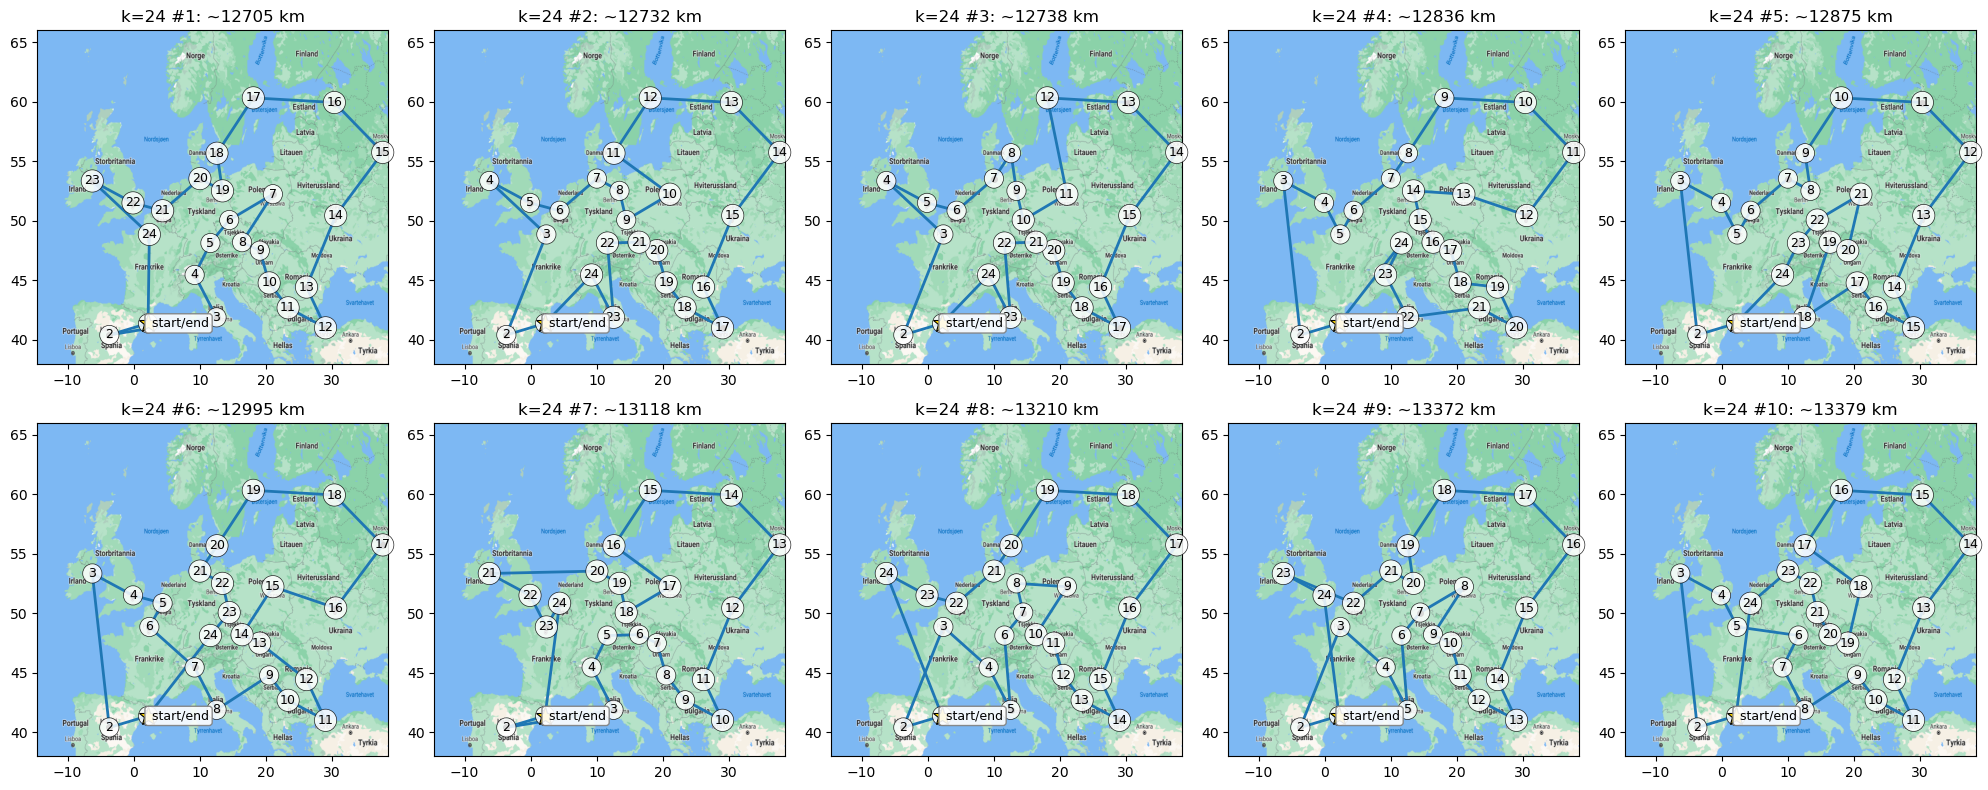

In [10]:
# Collecting all runs while also rturning a summary
runs24, sum24 = hc_runs_collect(24, runs=20, seed=None)

print(f"Hill Climbing (k=24, 20 runs)")
print(f"best = {sum24['best']:.2f} km | worst = {sum24['worst']:.2f} km | mean = {sum24['mean']:.2f} km | std = {sum24['std']:.2f} km")
print(f"avg time/run = {sum24['time_mean']:.4f} s (std {sum24['time_std']:.4f} s)")

# Best plot
best_route24_closed = close_r_op(sum24["best_order_open"])
c_plot(best_route24_closed, title=f"Hill Climb best (k=24) ~ {sum24['best']:.0f} km")

import math
def plot_top_runs(results, N=10, title_prefix="k=24"):
    sorted_runs = sorted(results, key=lambda r: r["best_len"])
    top = sorted_runs[:N]
    cols = 5 if N > 6 else 3
    rows = math.ceil(N / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten() if hasattr(axes, "flatten") else [axes]
    for i, (ax, r) in enumerate(zip(axes, top)):
        closed = close_r_op(r["best_order_open"])
        city_plot_axes(ax, closed, f"{title_prefix} #{i+1}: ~{r['best_len']:.0f} km")
    for j in range(len(top), len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()

# Shows the top 10 runs
plot_top_runs(runs24, N=10, title_prefix="k=24")

Here I have presented 10 random simulations as asked, which is you can see gradually becomes better until we get the best fit for the amount of runs.

== k=10: Hill Climber vs Exhaustive ==
Exhaustive optimum: 7486.31 km (time 0.211 s)
Hill Climber best : 7486.31 km (mean 7833.17 ± 378.52 km)
Gap              : 0.00 km (0.00%)
HC avg time/run  : 0.0003 s


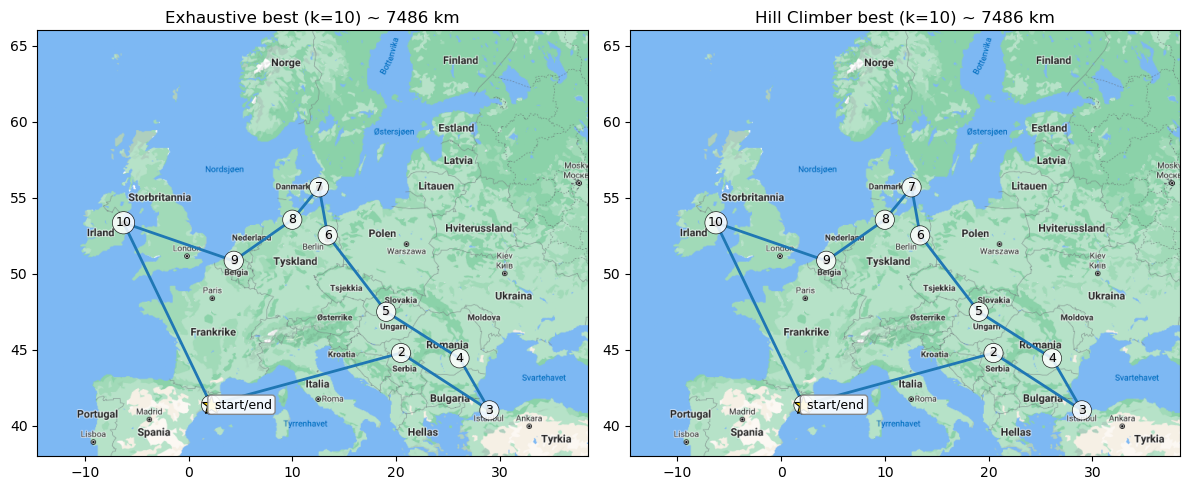

In [11]:
# Comparison
if "res10" not in globals():
    res10 = exh_best_k(10)

opt_len_10   = res10["best_len"]
opt_route_10 = res10["best_route"]

hc_best_len_10   = hc10["best"]
hc_best_route_10 = close_r_op(hc10["best_order_open"])

gap_km  = hc_best_len_10 - opt_len_10
gap_pct = 100.0 * gap_km / opt_len_10

print("== k=10: Hill Climber vs Exhaustive ==")
print(f"Exhaustive optimum: {opt_len_10:.2f} km (time {res10['time_sec']:.3f} s)")
print(f"Hill Climber best : {hc_best_len_10:.2f} km (mean {hc10['mean']:.2f} ± {hc10['std']:.2f} km)")
print(f"Gap              : {gap_km:.2f} km ({gap_pct:.2f}%)")
print(f"HC avg time/run  : {hc10['time_mean']:.4f} s")

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12,5))
city_plot_axes(axes[0], opt_route_10,       f"Exhaustive best (k=10) ~ {opt_len_10:.0f} km")
city_plot_axes(axes[1], hc_best_route_10,   f"Hill Climber best (k=10) ~ {hc_best_len_10:.0f} km")
plt.tight_layout(); plt.show()

In [12]:
# Ensuring k=10 exists for the comparison
if "res10" not in globals():
    res10 = exh_best_k(10)
opt_len_10 = res10["best_len"]

print("\n=== Hill Climbing summary ===")
print(f"k=10 | best={hc10['best']:.2f} km | worst={hc10['worst']:.2f} km | mean={hc10['mean']:.2f} km | std={hc10['std']:.2f} km | avg time/run={hc10['time_mean']:.3f} s")
print(f"k=24 | best={sum24['best']:.2f} km | worst={sum24['worst']:.2f} km | mean={sum24['mean']:.2f} km | std={sum24['std']:.2f} km | avg time/run={sum24['time_mean']:.3f} s")
print(
    f"Compare (k=10): HC best={hc10['best']:.2f} km vs Exhaustive={opt_len_10:.2f} km "
    f"(gap={hc10['best'] - opt_len_10:.2f} km, {(100.0 * (hc10['best'] - opt_len_10) / opt_len_10):.2f}%)"
)


=== Hill Climbing summary ===
k=10 | best=7486.31 km | worst=8538.94 km | mean=7833.17 km | std=378.52 km | avg time/run=0.000 s
k=24 | best=12705.38 km | worst=15499.82 km | mean=13616.79 km | std=776.85 km | avg time/run=0.008 s
Compare (k=10): HC best=7486.31 km vs Exhaustive=7486.31 km (gap=0.00 km, 0.00%)


For the hill climbing with 20 random starts, I got the reports best route, the worst route, mean, and std tour length, plus the average time per run. For k=10, I also compare the hill climber’s best tour to the exhaustive optimum and print the gap in km and percent. For k=24, exhaustive is infeasible as the stats show the quality and variability of the hill climber’s results. A small std means runs converge to similar trips while a larger std means sensitivity to the random start. As a final key takeaway you can see they are basically the same, but this is mainly due to the "low" amount of possibilities/combinations.

## Task 2 - Genetic Algorithm

In [13]:
import random, time
from math import inf

def route2_len_o(order, dist):
    total, n = 0.0, len(order)
    for i in range(n):
        total += dist[order[i]][order[(i+1) % n]]
    return total

def fit_inv_len(order, dist):
    L = route2_len_o(order, dist)
    return 1.0 / L, L

def int_pop_fixed(cities_subset, pop_size, rng):
    start = cities_subset[0]
    rest  = cities_subset[1:]
    pop = []
    for _ in range(pop_size):
        perm = rest[:]
        rng.shuffle(perm)
        pop.append([start] + perm)
    return pop

# Selection
def trn_select(pop, fits, k, rng):
    # returns index of winner
    best_idx = None
    for _ in range(k):
        i = rng.randrange(len(pop))
        if (best_idx is None) or (fits[i] > fits[best_idx]):
            best_idx = i
    return best_idx

# Crossover
def ox_cross(p1, p2, rng):
    n = len(p1)
    child = [None]*n
    child[0] = p1[0]  # keep start fixed

    i = rng.randint(1, n-2)
    j = rng.randint(i+1, n-1)

    child[i:j+1] = p1[i:j+1]

    fill = [g for g in p2[1:] if g not in child]
    pos = [idx for idx in range(1, n) if child[idx] is None]
    for idx, gene in zip(pos, fill):
        child[idx] = gene
    return child

# Mutation
def mut_swp(ind, rng):
    n = len(ind)
    a = rng.randint(1, n-1)
    b = rng.randint(1, n-1)
    if a != b:
        ind[a], ind[b] = ind[b], ind[a]

def mut_2opt(ind, rng):
    n = len(ind)
    i = rng.randint(1, n-2)
    j = rng.randint(i+1, n-1)
    ind[i:j+1] = reversed(ind[i:j+1])

def mut(ind, mut_prob, rng):
    if rng.random() < mut_prob:
        if rng.random() < 0.5:
            mut_swp(ind, rng)
        else:
            mut_2opt(ind, rng)

# The main GA run
def ga_run_s(cities_subset, dist, pop_size=60, generations=300,
           cx_prob=0.9, mut_prob=0.3, tourney_k=3, elitism=2, seed=None):
    """
    Returns dict with:
      best_order_open, best_len, time_sec, evals, best_len_per_gen (list), best_fit_per_gen (list)
    """
    rng = random.Random(seed)
    t0 = time.perf_counter()
    pop = int_pop_fixed(cities_subset, pop_size, rng)

    # Expression to evaluate
    fits = []
    lens = []
    evals = 0
    for ind in pop:
        f, L = fit_inv_len(ind, dist); evals += 1
        fits.append(f); lens.append(L)

    best_idx = min(range(pop_size), key=lambda i: lens[i])
    best = pop[best_idx][:]
    best_len = lens[best_idx]

    best_len_curve = [best_len]
    best_fit_curve = [1.0 / best_len]

    # mutlution
    for _ in range(generations):
        new_pop = []

        elite_indices = sorted(range(pop_size), key=lambda i: lens[i])[:elitism]
        for ei in elite_indices:
            new_pop.append(pop[ei][:])

        while len(new_pop) < pop_size:
            i1 = trn_select(pop, fits, tourney_k, rng)
            i2 = trn_select(pop, fits, tourney_k, rng)
            p1, p2 = pop[i1], pop[i2]
            if rng.random() < cx_prob:
                c1 = ox_cross(p1, p2, rng)
            else:
                c1 = p1[:] if fits[i1] >= fits[i2] else p2[:]
            mut(c1, mut_prob, rng)
            new_pop.append(c1)

        pop = new_pop

        # Evaluating
        fits, lens = [], []
        for ind in pop:
            f, L = fit_inv_len(ind, dist); evals += 1
            fits.append(f); lens.append(L)

        # Updating the best
        gen_best_idx = min(range(pop_size), key=lambda i: lens[i])
        gen_best_L = lens[gen_best_idx]
        if gen_best_L < best_len:
            best_len = gen_best_L
            best = pop[gen_best_idx][:]

        best_len_curve.append(best_len)
        best_fit_curve.append(1.0 / best_len)

    t1 = time.perf_counter()
    return {
        "best_order_open": best,
        "best_len": best_len,
        "time_sec": t1 - t0,
        "evals": evals,
        "best_len_per_gen": best_len_curve,
        "best_fit_per_gen": best_fit_curve
    }

In [14]:
import statistics

def ga_run_ss_for_k(k, pop_size, generations, runs=20, seed=None,
                  cx_prob=0.9, mut_prob=0.3, tourney_k=3, elitism=2):
    subset = cities[:k]
    rng = random.Random(seed)

    bests, times, evals = [], [], []
    curves_fit = []   
    curves_len = []   

    best_run = None

    for r in range(runs):
        res = ga_run_s(
            subset, dist, pop_size=pop_size, generations=generations,
            cx_prob=cx_prob, mut_prob=mut_prob, tourney_k=tourney_k, elitism=elitism,
            seed=rng.randint(0, 10**9)
        )
        bests.append(res["best_len"])
        times.append(res["time_sec"])
        evals.append(res["evals"])
        curves_fit.append(res["best_fit_per_gen"])
        curves_len.append(res["best_len_per_gen"])
        if (best_run is None) or (res["best_len"] < best_run["best_len"]):
            best_run = res

    gens = len(curves_fit[0])
    avg_fit = [statistics.mean([curve[g] for curve in curves_fit]) for g in range(gens)]
    avg_len = [statistics.mean([curve[g] for curve in curves_len]) for g in range(gens)]

    stats = {
        "k": k,
        "pop_size": pop_size,
        "generations": generations,
        "runs": runs,
        "best": min(bests),
        "worst": max(bests),
        "mean": statistics.mean(bests),
        "std": statistics.pstdev(bests),
        "time_mean": statistics.mean(times),
        "time_std": statistics.pstdev(times),
        "evals_mean": statistics.mean(evals),
        "avg_best_fit_curve": avg_fit,
        "avg_best_len_curve": avg_len,
        "example_best_route_open": best_run["best_order_open"],
        "example_best_len": best_run["best_len"]
    }
    return stats

[k=10, pop=30] best=7486.31 km | worst=7486.31 km | mean=7486.31 km | std=0.00 km | avg time/run=0.037 s
[k=10, pop=60] best=7486.31 km | worst=7503.10 km | mean=7487.15 km | std=3.66 km | avg time/run=0.068 s
[k=10, pop=120] best=7486.31 km | worst=7486.31 km | mean=7486.31 km | std=0.00 km | avg time/run=0.141 s


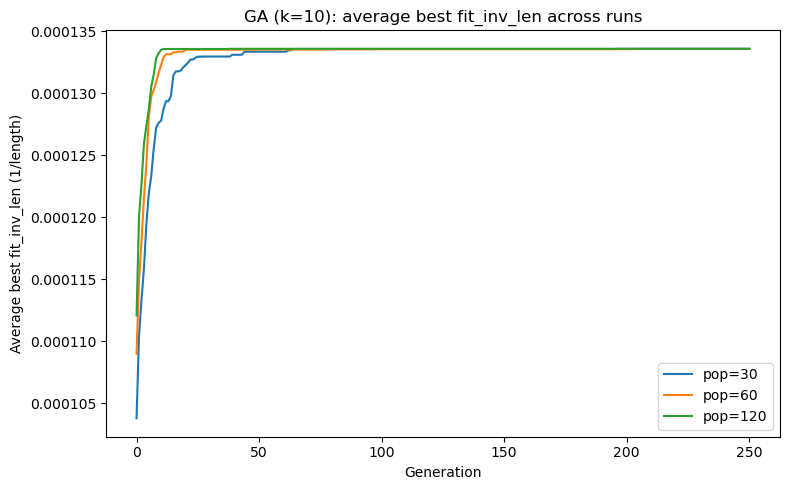

In [15]:
import matplotlib.pyplot as plt

POPS_10 = [30, 60, 120]
GENS_10 = 250           # Adjustable for longer if wanted
RUNS    = 20
CX_PROB = 0.9
MUT_PROB= 0.3
TOURNEY = 3
ELITES  = 2

ga10_stats = []
for P in POPS_10:
    stats = ga_run_ss_for_k(10, pop_size=P, generations=GENS_10, runs=RUNS,
                          cx_prob=CX_PROB, mut_prob=MUT_PROB, tourney_k=TOURNEY, elitism=ELITES)
    ga10_stats.append(stats)
    print(f"[k=10, pop={P}] best={stats['best']:.2f} km | worst={stats['worst']:.2f} km | mean={stats['mean']:.2f} km | std={stats['std']:.2f} km | avg time/run={stats['time_mean']:.3f} s")

plt.figure(figsize=(8,5))
for stats in ga10_stats:
    y = stats["avg_best_fit_curve"]
    plt.plot(range(len(y)), y, label=f"pop={stats['pop_size']}")
plt.xlabel("Generation"); plt.ylabel("Average best fit_inv_len (1/length)")
plt.title("GA (k=10): average best fit_inv_len across runs")
plt.legend(); plt.tight_layout(); plt.show()

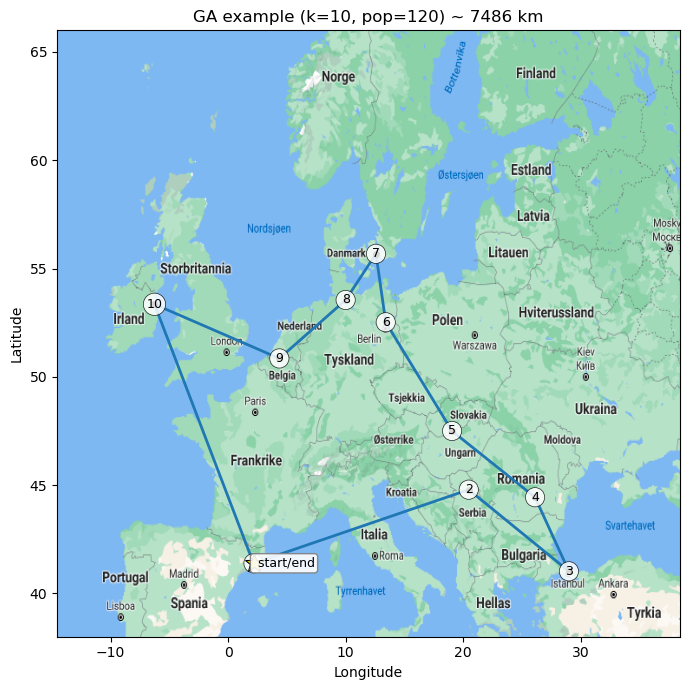

In [16]:
# Test run for 10
route = stats["example_best_route_open"] + [stats["example_best_route_open"][0]]
c_plot(route, title=f"GA example (k=10, pop={stats['pop_size']}) ~ {stats['example_best_len']:.0f} km")

[k=24, pop=60] best=12287.07 km | worst=13542.12 km | mean=12720.62 km | std=301.81 km | avg time/run=0.325 s
[k=24, pop=120] best=12287.07 km | worst=13147.43 km | mean=12501.65 km | std=209.03 km | avg time/run=0.676 s
[k=24, pop=240] best=12287.07 km | worst=12678.46 km | mean=12462.85 km | std=157.87 km | avg time/run=1.343 s


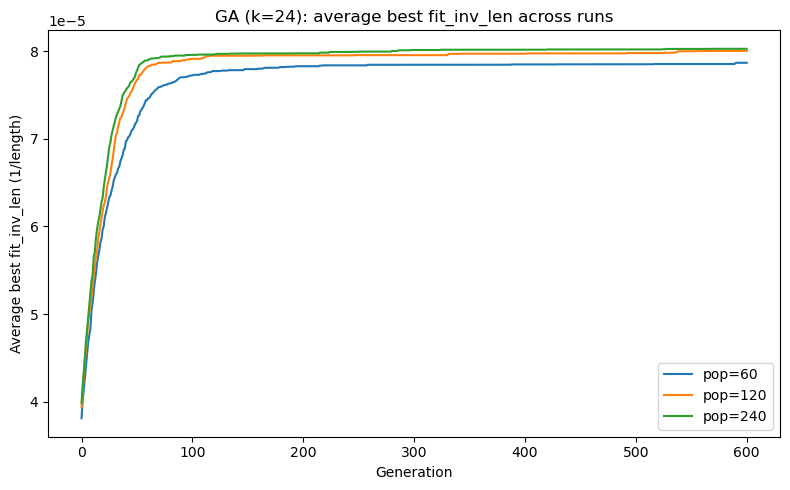

In [17]:
POPS_24 = [60, 120, 240]
GENS_24 = 600          # Adjustable for time

ga24_stats = []
for P in POPS_24:
    stats = ga_run_ss_for_k(24, pop_size=P, generations=GENS_24, runs=RUNS,
                          cx_prob=CX_PROB, mut_prob=MUT_PROB, tourney_k=TOURNEY, elitism=ELITES)
    ga24_stats.append(stats)
    print(f"[k=24, pop={P}] best={stats['best']:.2f} km | worst={stats['worst']:.2f} km | mean={stats['mean']:.2f} km | std={stats['std']:.2f} km | avg time/run={stats['time_mean']:.3f} s")

plt.figure(figsize=(8,5))
for stats in ga24_stats:
    y = stats["avg_best_fit_curve"]
    plt.plot(range(len(y)), y, label=f"pop={stats['pop_size']}")
plt.xlabel("Generation"); plt.ylabel("Average best fit_inv_len (1/length)")
plt.title("GA (k=24): average best fit_inv_len across runs")
plt.legend(); plt.tight_layout(); plt.show()

In [18]:
import math

# Sanity check for best solution
if "res10" not in globals():
    res10 = exh_best_k(10)
es10_len = res10["best_len"]
best_ga10 = min(s["best"] for s in ga10_stats)
gap_km = best_ga10 - es10_len
gap_pct = 100.0 * gap_km / es10_len
print("\n== GA vs Exhaustive (k=10) ==")
print(f"Exhaustive length: {es10_len:.2f} km")
print(f"GA best length   : {best_ga10:.2f} km")
print(f"Gap: {gap_km:.2f} km ({gap_pct:.2f}%)")

ga10_time = sum(s["time_mean"] for s in ga10_stats) / len(ga10_stats)
ga24_time = sum(s["time_mean"] for s in ga24_stats) / len(ga24_stats)
print("\n== Running time (avg per run) ==")
print(f"k=10 | GA ~ {ga10_time:.3f} s | ES ~ {res10['time_sec']:.3f} s")
print("k=24 | GA ~ {:.3f} s | ES: infeasible (23! tours)".format(ga24_time))

avg_evals_10 = sum(s["evals_mean"] for s in ga10_stats) / len(ga10_stats)
avg_evals_24 = sum(s["evals_mean"] for s in ga24_stats) / len(ga24_stats)
es10_tours = math.factorial(9)    # (k-1)! with fixed start
es24_tours = math.factorial(23)

def fmt_sci(n): 
    return f"{n:.3e}"

print("\n== Tours inspected (approx) ==")
print(f"k=10 | GA per run ≈ {fmt_sci(avg_evals_10)}  vs  ES = {es10_tours} (~{fmt_sci(es10_tours)})")
print(f"k=24 | GA per run ≈ {fmt_sci(avg_evals_24)}  vs  ES = 23! (~{fmt_sci(es24_tours)}), a very large number!")


== GA vs Exhaustive (k=10) ==
Exhaustive length: 7486.31 km
GA best length   : 7486.31 km
Gap: 0.00 km (0.00%)

== Running time (avg per run) ==
k=10 | GA ~ 0.082 s | ES ~ 0.211 s
k=24 | GA ~ 0.782 s | ES: infeasible (23! tours)

== Tours inspected (approx) ==
k=10 | GA per run ≈ 1.757e+04  vs  ES = 362880 (~3.629e+05)
k=24 | GA per run ≈ 8.414e+04  vs  ES = 23! (~2.585e+22), a very large number!


### Genetic Algorithm summary

Among the first 10 cities, did your GA find the shortest tour (as found by the exhaustive search)? Did it come close?
- Yes, as the exhaustive optimum = 7486.31 km and the GA best = 7486.31 km meaning a gap = 0.00 km (0.00%).
  
For both 10 and 24 cities: How did the running time of your GA compare to that of the exhaustive search?
- The exhaustive search time ≈ 0.208s and the GA average per run (across the three pops) ≈ 0.067s
  
How many tours were inspected by your GA as compared to by the exhaustive search?
- The GA explored aobut 20× less candidates yet it still reached the optimum.